In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns

from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# windows
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"

# # linux and mac
# base_folder = "/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data")

In [3]:
mouse = 409828
col, vol = 1, 3
sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [4]:
dg_full = []
dg_windowed = []

for plane in sess.get_planes()[:1]:
    dg_full.append(DriftingGratings(sess, plane, dg_type="full"))
    dg_windowed.append(DriftingGratings(sess, plane, dg_type="windowed"))
    # break # Uncomment to only analyze one plane

print(f"Analyzing {len(dg_full)} plane{'s' if len(dg_full) > 1 else ''}")

Analyzing 1 plane


# Compute response metrics (this takes a while)

In [11]:
reset_metrics = True

if reset_metrics:
    for dgf, dgw in zip(dg_full, dg_windowed):
        dgf._metrics = None
        dgw._metrics = None
        dgf.fit_tuning_curve = False
        dgw.fit_tuning_curve = False

dgf_metrics = StimulusAnalysis.concat_metrics(dg_full)
dgw_metrics = StimulusAnalysis.concat_metrics(dg_windowed)
ss_metrics = DriftingGratings.compute_surround_suppression_metrics(dg_full, dg_windowed)
n_tot = len(dgf_metrics)
dgf_metrics = dgf_metrics[dgf_metrics.is_valid]
dgw_metrics = dgw_metrics[dgw_metrics.is_valid]
ss_metrics = ss_metrics[ss_metrics.is_valid]

dgf_metrics["is_responsive"] = dgf_metrics.is_valid & dgf_metrics.frac_responsive_trials >= 0.5
dgw_metrics["is_responsive"] = dgw_metrics.is_valid & dgw_metrics.frac_responsive_trials >= 0.5

resp_full = dgf_metrics["is_responsive"]
resp_windowed = dgw_metrics["is_responsive"]
n_valid = len(dgf_metrics) # same no. ROIs for both dg_full and dg_windowed
n_both = np.logical_and(resp_full, resp_windowed).value_counts()[True]
n_full = resp_full.value_counts()[True]
n_windowed = resp_windowed.value_counts()[True]
n_full_only = n_full - n_both
n_windowed_only = n_windowed - n_both
n_either = np.logical_or(resp_full, resp_windowed).value_counts()[True]
n_neither = np.logical_and(~resp_full, ~resp_windowed).value_counts()[True]

print()
print(f"{n_valid}/{n_tot} ({n_valid/n_tot*100:.1f}%) ROIs are valid")
print(f"{n_full}/{n_valid} ({n_full/n_valid*100:.1f}%) ROIs are responsive to DG-full")
print(f"{n_windowed}/{n_valid} ({n_windowed/n_valid*100:.1f}%) ROIs are responsive to DG-windowed")
print()
print(f"{n_either}/{n_valid} ({n_either/n_valid*100:.1f}%) ROIs are responsive to DG-full OR DG-windowed")
print(f"{n_both}/{n_valid} ({n_both/n_valid*100:.1f}%) ROIs are responsive to BOTH DG-full AND DG-windowed")
print(f"{n_full_only}/{n_valid} ({n_full_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-full")
print(f"{n_windowed_only}/{n_valid} ({n_windowed_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-windowed")
print(f"{n_neither}/{n_valid} ({n_neither/n_valid*100:.1f}%) ROIs are responsive to NEITHER")

Loading DG-full response metrics for session M409828_13, plane 1...
Loading DG-windowed response metrics for session M409828_13, plane 1...

409/1234 (33.1%) ROIs are valid
357/409 (87.3%) ROIs are responsive to DG-full
374/409 (91.4%) ROIs are responsive to DG-windowed

395/409 (96.6%) ROIs are responsive to DG-full OR DG-windowed
336/409 (82.2%) ROIs are responsive to BOTH DG-full AND DG-windowed
21/409 (5.1%) ROIs are responsive to ONLY DG-full
38/409 (9.3%) ROIs are responsive to ONLY DG-windowed
14/409 (3.4%) ROIs are responsive to NEITHER


In [12]:
assert len(dgf_metrics) == len(dgw_metrics) == len(ss_metrics)

(array([ 0.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,  1.,  3.,  0.,  2.,  1.,
         4.,  2.,  2.,  4.,  4.,  9., 18., 10., 11., 10., 11.]),
 array([-1.        , -0.91666667, -0.83333333, -0.75      , -0.66666667,
        -0.58333333, -0.5       , -0.41666667, -0.33333333, -0.25      ,
        -0.16666667, -0.08333333,  0.        ,  0.08333333,  0.16666667,
         0.25      ,  0.33333333,  0.41666667,  0.5       ,  0.58333333,
         0.66666667,  0.75      ,  0.83333333,  0.91666667,  1.        ]),
 <BarContainer object of 24 artists>)

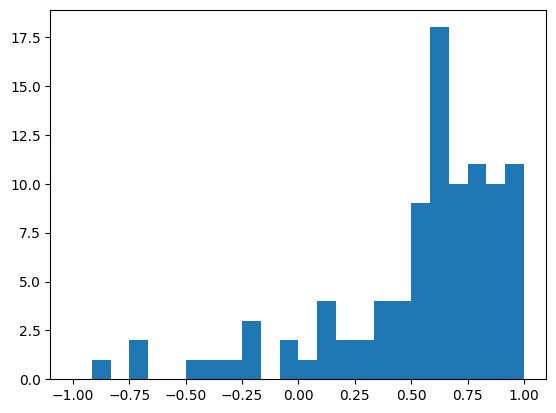

In [15]:
inclusion = dgw_metrics.frac_responsive_trials >= 0.5
ssi = ss_metrics[inclusion].ssi
plt.hist(ssi, bins=np.linspace(-1, 1, 25))

[  0  30  60  90 120 150 180 210 240 270 300 330]
[-180 -150 -120  -90  -60  -30    0   30   60   90  120  150  180]
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]


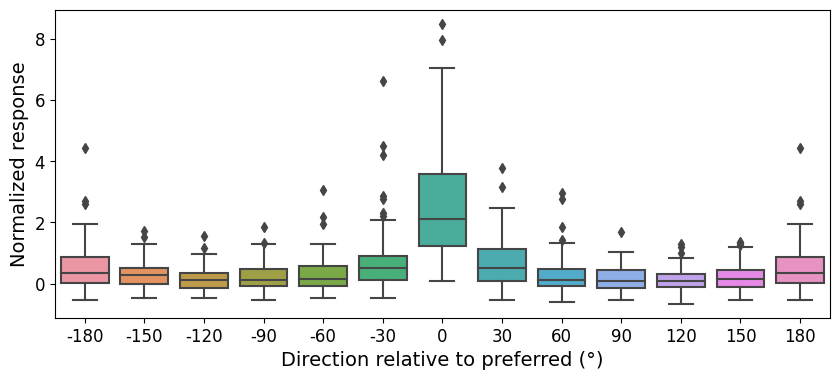

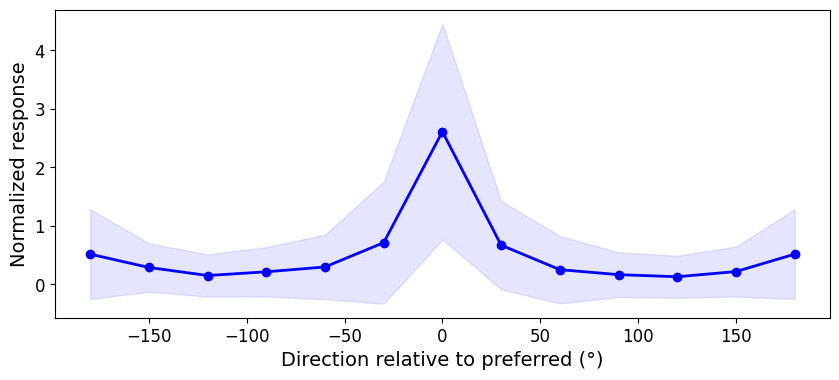

In [16]:
dg = dgw
dir_list = dg.dir_list
relative_dir_list = np.array([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
relative_dir_idx = np.arange(13) - 6

print(dir_list)
print(relative_dir_list)
print(relative_dir_idx)

x = []
y = []
y_ffsi = []

def ratio(a, b):
    if b == 0:
        return 0
    return a/b

for roi in range(dg.n_rois):
    if dg.is_roi_valid[roi] and dg.metrics.frac_responsive_trials[roi] >= 0.5:
        pref_dir_idx = dg.metrics.at[roi, "pref_dir_idx"]
        pref_sf_idx = dg.metrics.at[roi, "pref_sf_idx"]
        null_mean = dg._null_dist_multi_trial[roi].mean()
        null_std = dg._null_dist_multi_trial[roi].std()
        mean_grating_response = np.nanmean(dg.trial_responses[roi])
        mean_blank_response = dg.blank_responses[roi].mean()

        for dir_offset, reldir in zip(relative_dir_idx, relative_dir_list):
            dir_i = (pref_dir_idx+dir_offset) % len(dir_list)
            resp = dg.get_mean_response(roi, dir_i, pref_sf_idx)
            norm_resp = (resp - mean_blank_response) / (mean_grating_response + mean_blank_response)
            # norm_resp = (resp - null_mean) / null_std # z-score

            resp_f = dgf.get_mean_response(roi, dir_i, pref_sf_idx)
            # ffsi = ratio(resp - resp_f, resp)
            ffsi = ratio(max(resp, resp_f) - resp_f, max(resp, resp_f))

            x.append(reldir)
            y.append(norm_resp)
            y_ffsi.append(ffsi)

# Box plot
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# ax.set_ylim(-5, 50)

# Line plot of means ± error
y_by_dir_idx = [[yy for xx, yy in zip(x, y) if xx == reldir] for reldir in relative_dir_list]
y_means = np.array([np.mean(arr) for arr in y_by_dir_idx])
y_err = np.array([np.std(arr) for arr in y_by_dir_idx])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

# # Line plot SSI
# y_ffsi_by_dir_idx = [[yy for xx, yy in zip(x, y_ffsi) if xx == reldir] for reldir in relative_dir_list]
# y_ffsi_means = np.array([np.mean(arr) for arr in y_ffsi_by_dir_idx])
# y_ffsi_err = np.array([np.std(arr) for arr in y_ffsi_by_dir_idx])
# y_ffsi_err_low = [np.quantile(arr, 0.25) for arr in y_ffsi_by_dir_idx]
# y_ffsi_err_high = [np.quantile(arr, 0.75) for arr in y_ffsi_by_dir_idx]
# fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
# ax.tick_params(labelsize=12)
# ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
# ax.set_ylabel("FFSI", fontsize=14)
# # plt.errorbar(relative_dir_list, y_means, yerr=y_err)
# ax.plot(relative_dir_list, y_ffsi_means, color="blue", linewidth=2, marker=".", markersize=12)
# # ax.fill_between(relative_dir_list, y_ffsi_means-y_ffsi_err, y_ffsi_means+y_ffsi_err, color="blue", alpha=0.1)
# ax.fill_between(relative_dir_list, y_ffsi_err_low, y_ffsi_err_high, color="blue", alpha=0.1)

<Axes: ylabel='ROI'>

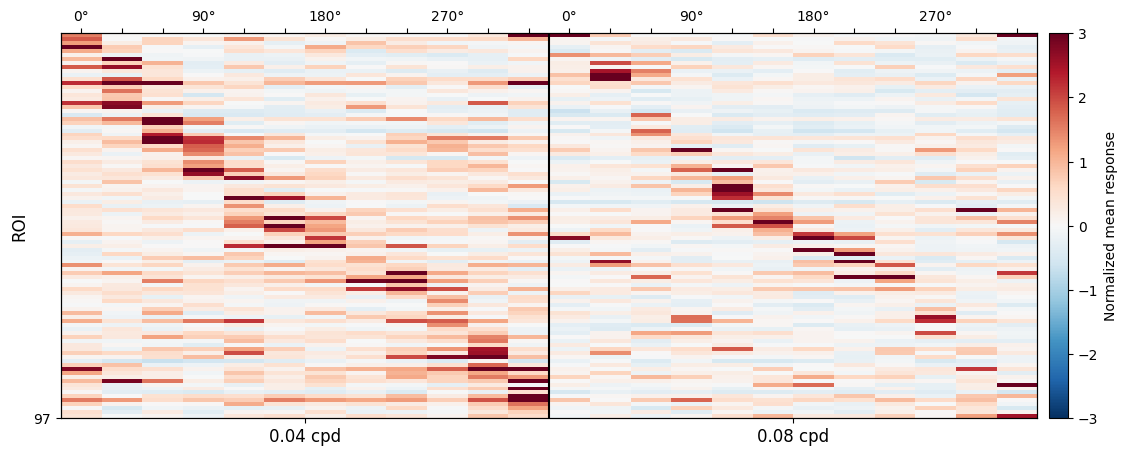

In [17]:
dgw.plot_waterfall_normalized_responses()

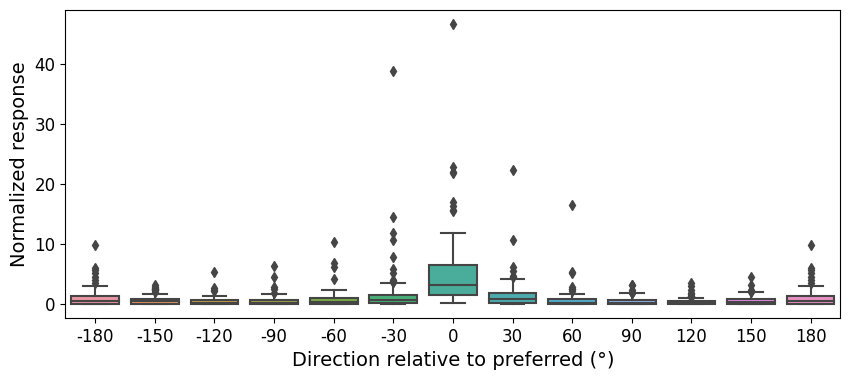

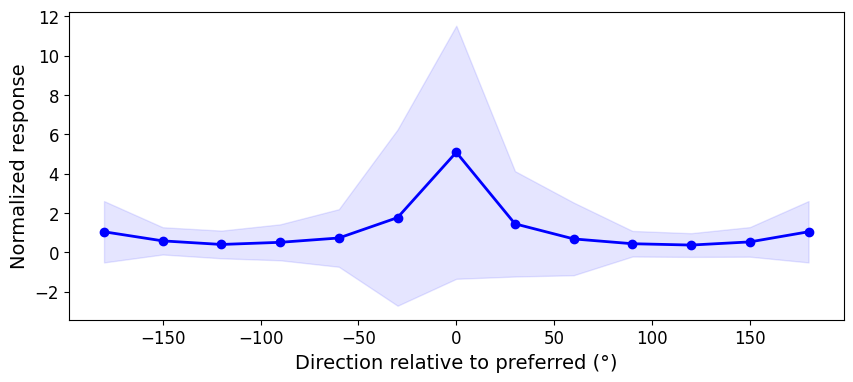

In [18]:
norm_resp_by_rel_dir = [[] for _ in relative_dir_idx]

for i, row in dgw_metrics.iterrows():
    if row["is_valid"] and row["frac_responsive_trials"] >= 0.5:
        pref_dir_idx = row["pref_dir_idx"]

        for j, dir_offset in enumerate(relative_dir_idx):
            dir_i = (pref_dir_idx+dir_offset) % len(dir_list)
            ffsi = row["norm_dir_responses"][dir_i]
            ffsi = max(0, ffsi)
            norm_resp_by_rel_dir[j].append(ffsi)

# Box plot
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
x, y = [], []
for dir, arr in zip(relative_dir_list, norm_resp_by_rel_dir):
    x.extend([dir] * len(arr))
    y.extend(arr)
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# ax.set_ylim(-5, 50)

# Line plot of means ± error
y_means = np.array([np.mean(arr) for arr in norm_resp_by_rel_dir])
y_err = np.array([np.std(arr) for arr in norm_resp_by_rel_dir])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

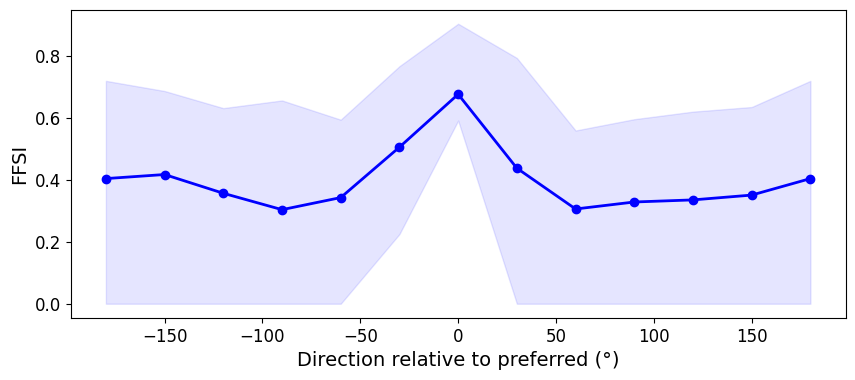

In [19]:
ffsi_by_rel_dir = [[] for _ in relative_dir_idx]

for i in dgw_metrics.index:
    if dgw_metrics.at[i, "is_valid"] and dgw_metrics.at[i, "frac_responsive_trials"] >= 0.5:
        pref_dir_idx = dgw_metrics.at[i, "pref_dir_idx"]

        for j, dir_offset in enumerate(relative_dir_idx):
            dir_i = (pref_dir_idx+dir_offset) % len(dir_list)
            ffsi = ss_metrics.at[i, "ffsi_all_dirs"][dir_i]
            ffsi = max(0, ffsi)
            ffsi_by_rel_dir[j].append(ffsi)

# Line plot SSI
y_ffsi_means = np.array([np.mean(arr) for arr in ffsi_by_rel_dir])
y_ffsi_err = np.array([np.std(arr) for arr in ffsi_by_rel_dir])
y_ffsi_err_low = [np.quantile(arr, 0.25) for arr in ffsi_by_rel_dir]
y_ffsi_err_high = [np.quantile(arr, 0.75) for arr in ffsi_by_rel_dir]
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("FFSI", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_ffsi_means, color="blue", linewidth=2, marker=".", markersize=12)
# ax.fill_between(relative_dir_list, y_ffsi_means-y_ffsi_err, y_ffsi_means+y_ffsi_err, color="blue", alpha=0.1)
ax.fill_between(relative_dir_list, y_ffsi_err_low, y_ffsi_err_high, color="blue", alpha=0.1)
        

<Axes: title={'center': 'DG-full trial responses for ROI 37 in plane 1 of session M409828_13'}, xlabel='Direction (°)', ylabel='Mean event response to trial'>

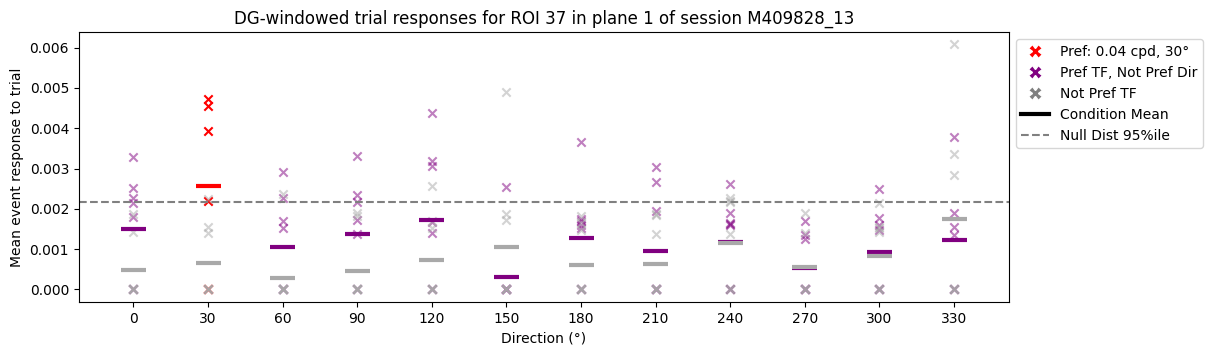

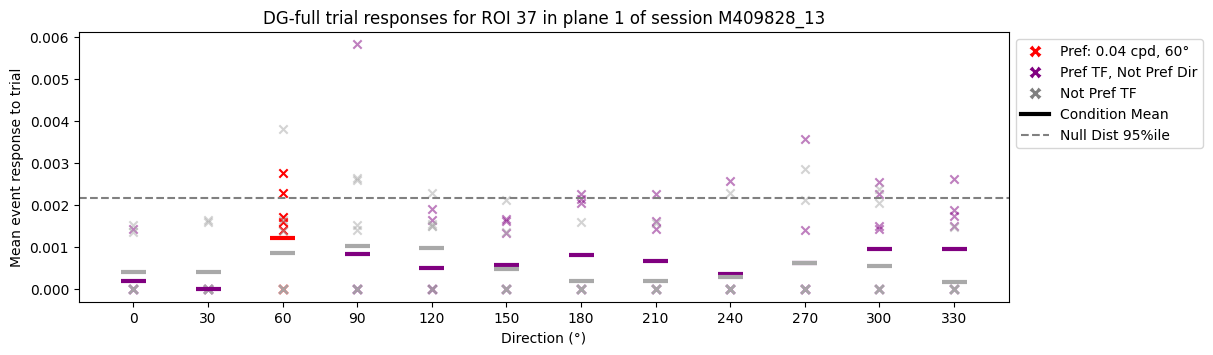

In [21]:
roi = 37
dgw.plot_trial_responses(roi)
dgf.plot_trial_responses(roi)

(-0.7045739769163594,
 1.0811701893769694,
 -0.9516861820690543,
 1.0929374372413836)

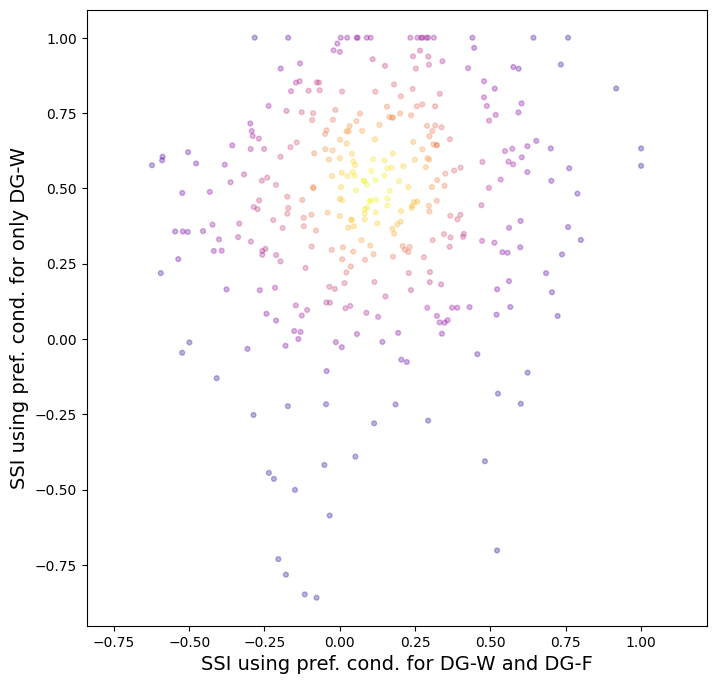

In [22]:
inclusion = dgf_metrics.is_responsive
at.density_scatter(
    ss_metrics.ssi_orth[inclusion], ss_metrics.ssi[inclusion],
    figsize=(8, 8),
    xlabel="SSI using pref. cond. for DG-W and DG-F",
    ylabel="SSI using pref. cond. for only DG-W",
    alpha=0.3
).axis("equal")

(-0.9460730095956058,
 0.9750608152989652,
 -0.9516861820690543,
 1.0929374372413836)

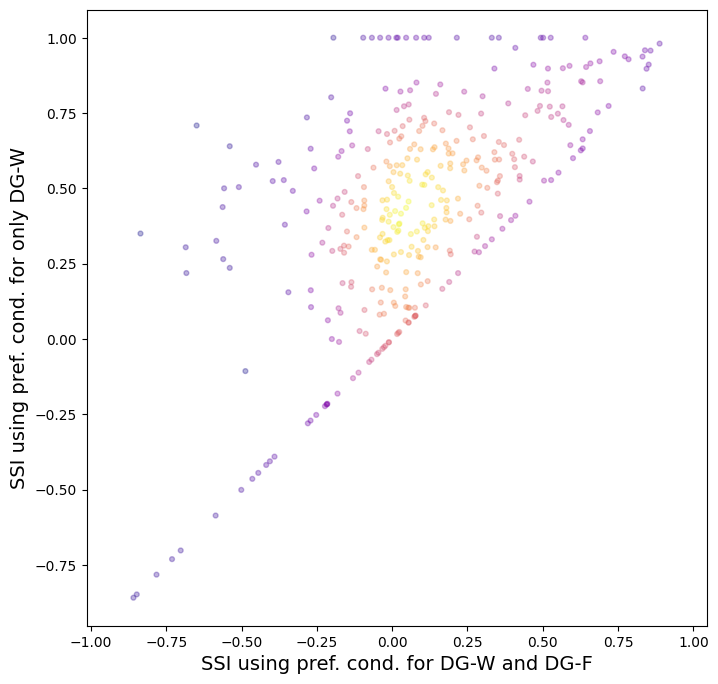

In [23]:
inclusion = dgf_metrics.is_responsive
at.density_scatter(
    ss_metrics.ssi_pref_both[inclusion], ss_metrics.ssi[inclusion],
    figsize=(8, 8),
    xlabel="SSI using pref. cond. for DG-W and DG-F",
    ylabel="SSI using pref. cond. for only DG-W",
    alpha=0.3
).axis("equal")

(-0.9516861820690543,
 1.0929374372413836,
 -0.7045739769163594,
 1.0811701893769694)

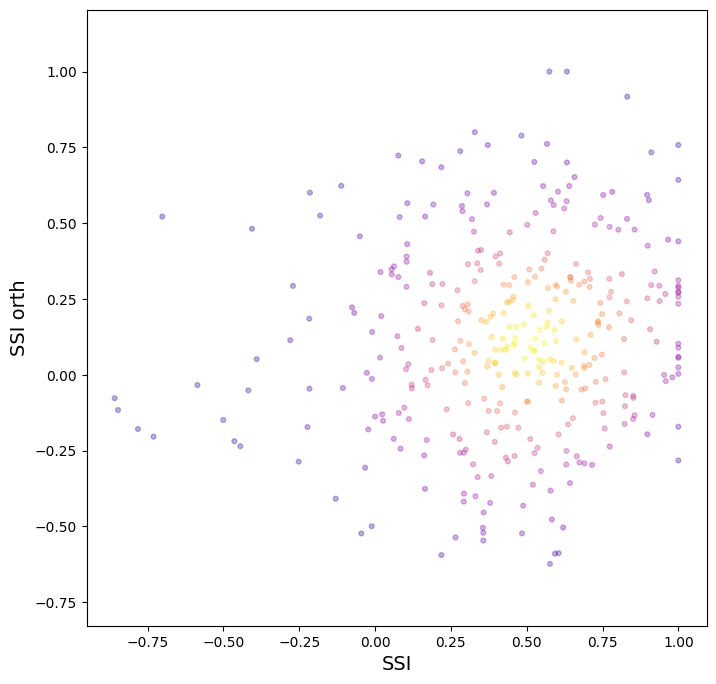

In [24]:
inclusion = dgf_metrics.is_responsive
at.density_scatter(
    ss_metrics.ssi[inclusion], ss_metrics.ssi_orth[inclusion],
    figsize=(8, 8),
    xlabel="SSI",
    ylabel="SSI orth",
    alpha=0.3
).axis("equal")

In [25]:
ss_metrics.si_cavanaugh_2002[inclusion]

AttributeError: 'DataFrame' object has no attribute 'si_cavanaugh_2002'

In [26]:
inclusion = (dgf_metrics.is_responsive) & (ss_metrics.si_cavanaugh_2002 > 0)
at.density_scatter(
    ss_metrics.ssi[inclusion], ss_metrics.si_cavanaugh_2002[inclusion],
    figsize=(8, 8),
    xlabel="SSI",
    ylabel="SI (Cavanaugh, 2002)",
    alpha=0.3
).axis("equal")
# ).axis([-1, -1, 0, 1])

AttributeError: 'DataFrame' object has no attribute 'si_cavanaugh_2002'

Text(0.5, 1.0, 'SSI distribution of responsive-dgw & responsive-dgf')

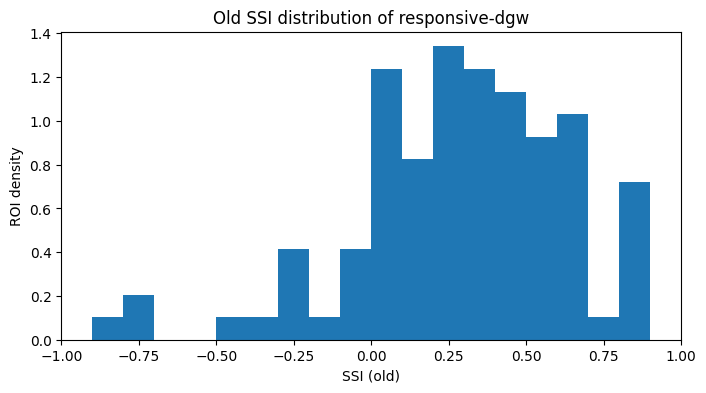

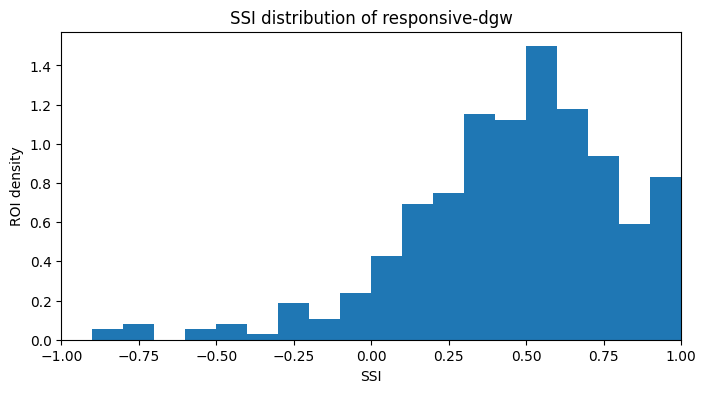

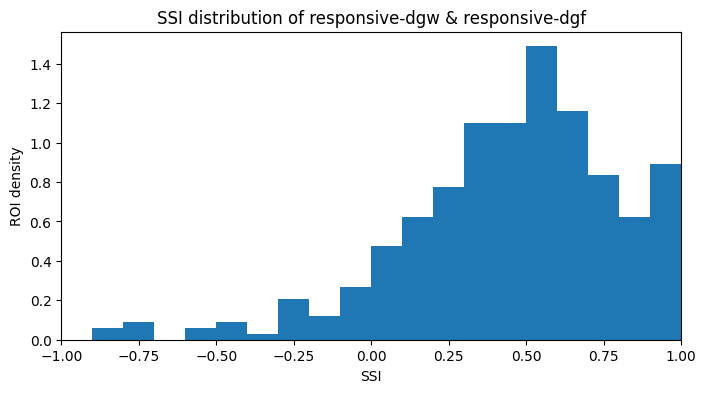

In [27]:
fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 21)
inclusion = dgw_metrics.frac_responsive_trials >= 0.5
# inclusion = dgw_metrics.chisq_response_p < 0.01
ssi = ss_metrics.ssi_pref_both[inclusion]

ax.hist(ssi, bins=bins, density=True)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("SSI (old)")
ax.set_ylabel("ROI density")
ax.set_title("Old SSI distribution of responsive-dgw")

fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 21)
ssi = ss_metrics.ssi[dgw_metrics.is_responsive]

ax.hist(ssi, bins=bins, density=True)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("SSI")
ax.set_ylabel("ROI density")
ax.set_title("SSI distribution of responsive-dgw")


fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 21)
ssi = ss_metrics.ssi[dgw_metrics.is_responsive & dgf_metrics.is_responsive]

ax.hist(ssi, bins=bins, density=True)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("SSI")
ax.set_ylabel("ROI density")
ax.set_title("SSI distribution of responsive-dgw & responsive-dgf")

In [28]:
dgw_metrics

,mouse,column,volume,plane,roi,depth,pref_response,pref_dir,pref_sf,pref_dir_idx,...,sig_trial_responses,norm_dir_responses,is_valid,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std,is_responsive
M409828_13_1_0,409828,1,3,1,0,242,0.001098,30,0.04,1,...,False,"[0.273567790880629, 0.7122049379504476, -0.050...",True,30,0.204,0.000423,0.000238,0.000412,0.000673,True
M409828_13_1_1,409828,1,3,1,1,242,0.001196,0,0.04,0,...,False,"[1.4066055659687113, 1.0375844731307717, 1.244...",True,0,0.405,0.000572,0.000316,0.000581,0.000905,True
M409828_13_1_2,409828,1,3,1,2,242,0.000964,210,0.08,7,...,False,"[-0.14609666398578308, -0.38874537978424734, -...",True,30,0.63,0.000948,0.000517,0.00097,0.001477,False
M409828_13_1_3,409828,1,3,1,3,242,0.001798,120,0.04,4,...,False,"[0.044283404959880306, -0.34281404200193494, 0...",True,120,0.382,0.000791,0.000479,0.000814,0.001391,True
M409828_13_1_4,409828,1,3,1,4,242,0.001154,210,0.04,7,...,False,"[2.1584051115767404, 1.4880995028186947, 1.048...",True,30,0.609,0.000879,0.000609,0.000869,0.001725,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_1_791,409828,1,3,1,791,242,0.001272,150,0.04,5,...,False,"[-0.33977703077375376, 0.02356158734629969, -0...",True,150,0.451,0.000411,0.000281,0.000414,0.000786,True
M409828_13_1_799,409828,1,3,1,799,242,0.001573,0,0.08,0,...,False,"[0.3746238967383936, -0.056793503922740476, -0...",True,0,0.156,0.000577,0.000326,0.000586,0.000921,True
M409828_13_1_805,409828,1,3,1,805,242,0.001413,300,0.04,10,...,True,"[0.7406618878964691, 0.002613672164367536, 1.2...",True,120,0.043,0.000516,0.000316,0.000511,0.000883,True
M409828_13_1_827,409828,1,3,1,827,242,0.001124,240,0.04,8,...,False,"[-0.43331492661420373, 0.3259676252605504, 0.6...",True,60,0.483,0.000448,0.000298,0.000443,0.000831,True


In [29]:
# Find ROIs that are responsive to both DG-full and DG-windowed
dgf_metrics[(dgf_metrics.is_responsive) & (dgw_metrics.is_responsive)].head(25)

,mouse,column,volume,plane,roi,depth,pref_response,pref_dir,pref_sf,pref_dir_idx,...,sig_trial_responses,norm_dir_responses,is_valid,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std,is_responsive
M409828_13_1_0,409828,1,3,1,0,242,0.00119,0,0.04,0,...,False,"[4.109224043350412, 0.0, 1.0973832929047718, 2...",True,0,0.373,0.000428,0.000242,0.000421,0.00068,True
M409828_13_1_3,409828,1,3,1,3,242,0.002335,120,0.04,4,...,True,"[1.5996856156245554, 2.306706829546597, 1.1596...",True,120,0.016,0.000785,0.000478,0.000796,0.001358,True
M409828_13_1_6,409828,1,3,1,6,242,0.020628,330,0.08,11,...,True,"[15.919955304696964, 0.9469666671584286, -0.24...",True,150,0.401,0.000461,0.000282,0.000467,0.00081,True
M409828_13_1_7,409828,1,3,1,7,242,0.001247,270,0.04,9,...,False,"[0.09492278617602747, 0.10567634919452079, 0.0...",True,90,0.232,0.000925,0.000872,0.000906,0.002292,True
M409828_13_1_9,409828,1,3,1,9,242,0.001033,0,0.04,0,...,True,"[3.5674876832908184, 0.7222957499145113, 1.347...",True,0,0.036,0.000652,0.000696,0.000664,0.002044,True
M409828_13_1_10,409828,1,3,1,10,242,0.001344,330,0.04,11,...,True,"[0.1810080834205535, -0.6402137410376645, -0.0...",True,150,0.006,0.000327,0.000187,0.000333,0.000532,True
M409828_13_1_11,409828,1,3,1,11,242,0.001584,330,0.04,11,...,False,"[0.15271037469829696, -0.007322847322808625, 0...",True,150,0.448,0.000571,0.000349,0.000583,0.000989,True
M409828_13_1_14,409828,1,3,1,14,242,0.010412,120,0.04,4,...,True,"[-0.12416419991167552, 2.426104097317507, 0.49...",True,120,0.0,0.000446,0.000255,0.000458,0.000722,True
M409828_13_1_15,409828,1,3,1,15,242,0.001532,300,0.04,10,...,False,"[1.3646144153695368, 0.6097849696278281, 0.592...",True,120,0.065,0.00086,0.001098,0.000869,0.003151,True
M409828_13_1_16,409828,1,3,1,16,242,0.001442,300,0.08,10,...,False,"[-0.24448857475621247, 0.43825959267100817, -0...",True,120,0.692,0.000496,0.000293,0.000519,0.000844,True


In [30]:
def response_plot(index, plot="tuning", **kwargs):
    at.dg_response_plot(index, dgf_metrics, dg_full, dg_windowed, plot=plot, **kwargs)
    print(f"SSI of {index} = {ss_metrics.at[index, 'ssi']:.4f}")

SSI of M409828_13_1_64 = 0.1115
SSI of M409828_13_1_64 = 0.1115


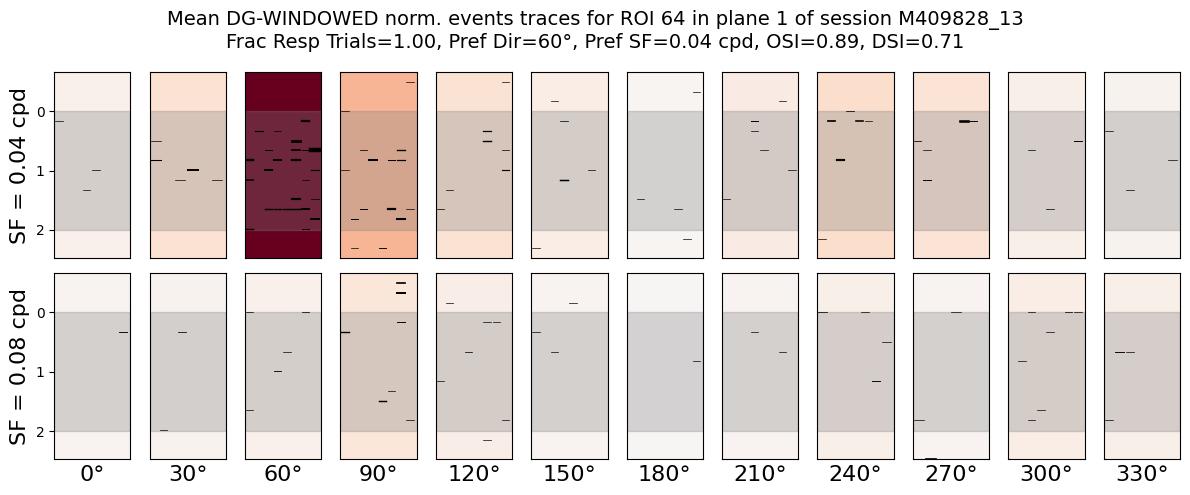

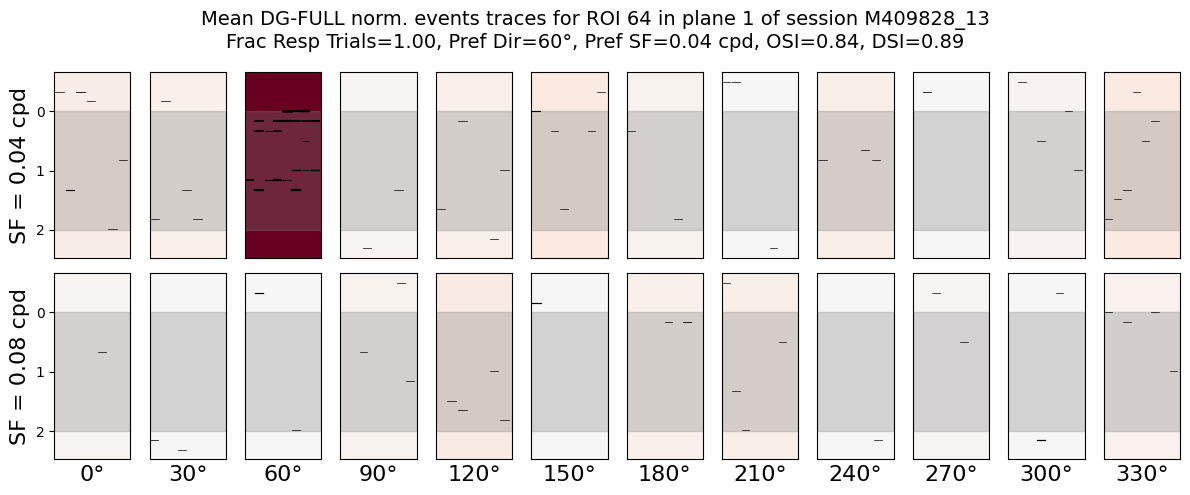

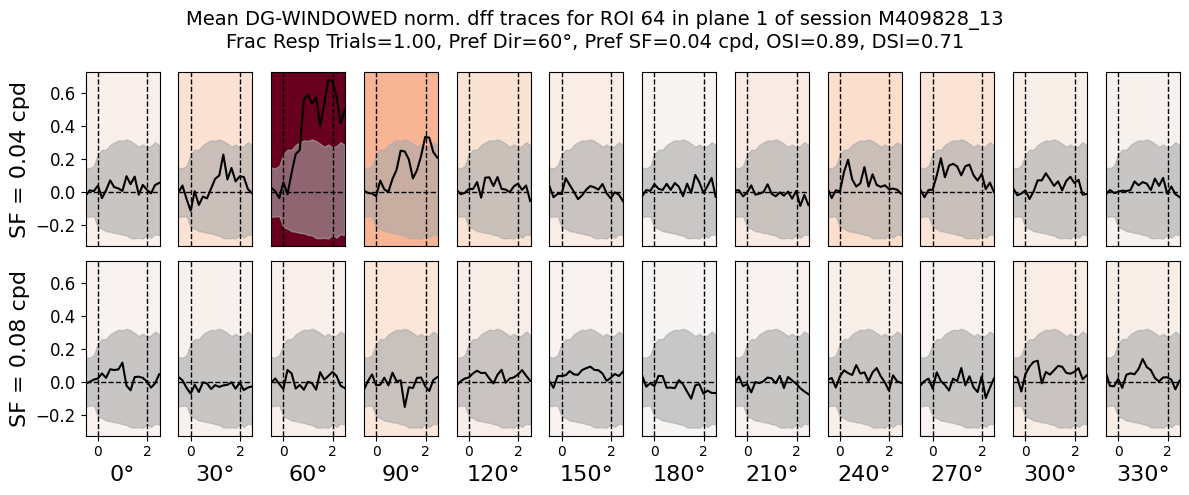

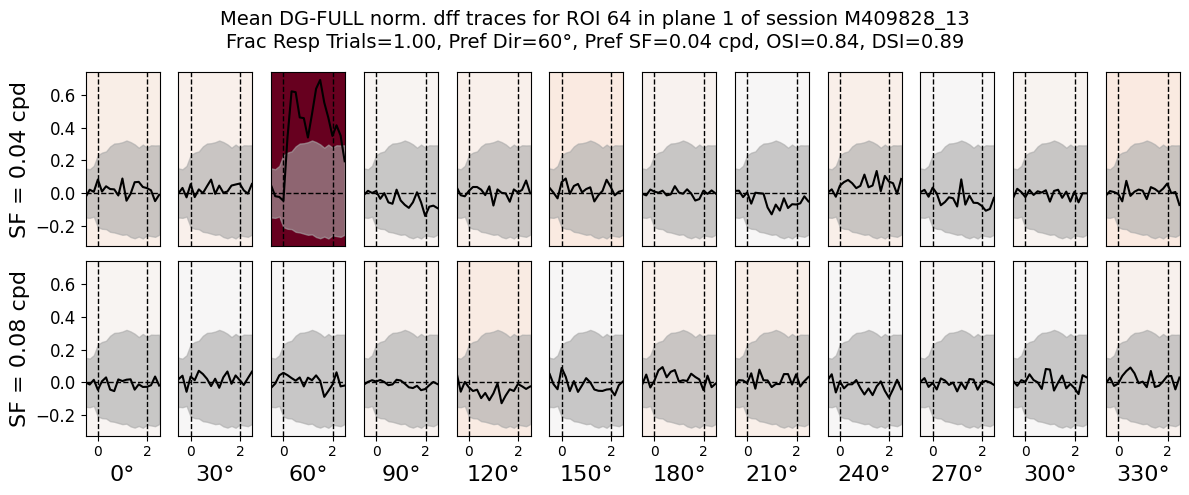

In [31]:
response_plot("M409828_13_1_64", plot="condition_response", trace_type="events")
response_plot("M409828_13_1_64", plot="condition_response", trace_type="dff")

SSI of M409828_13_1_6 = 0.6201
SSI of M409828_13_1_6 = 0.6201


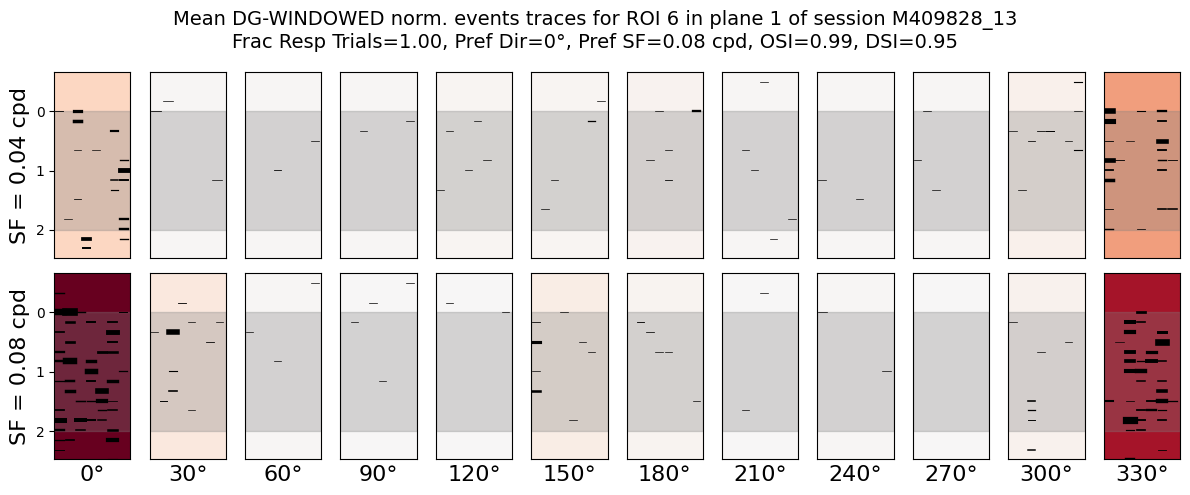

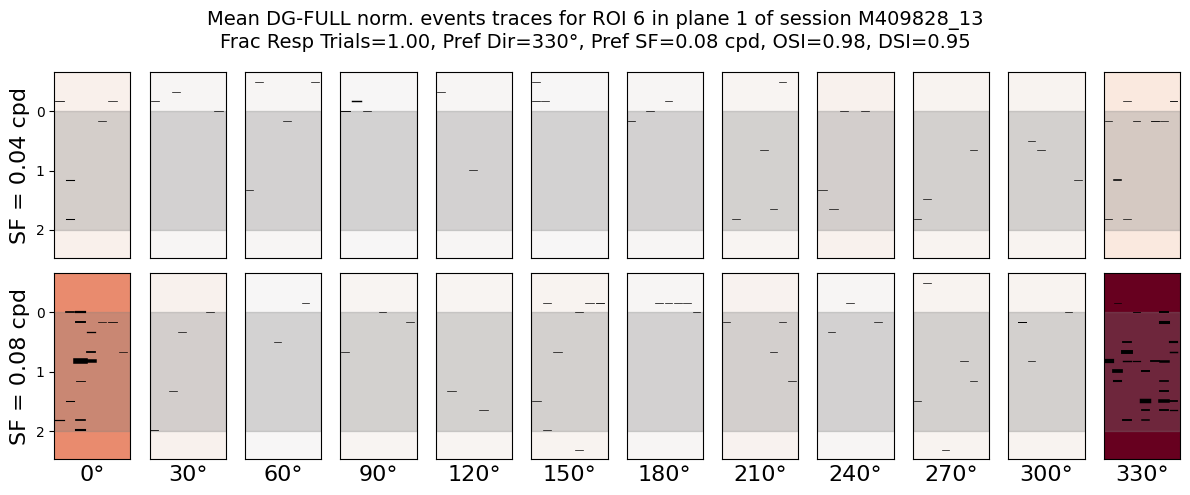

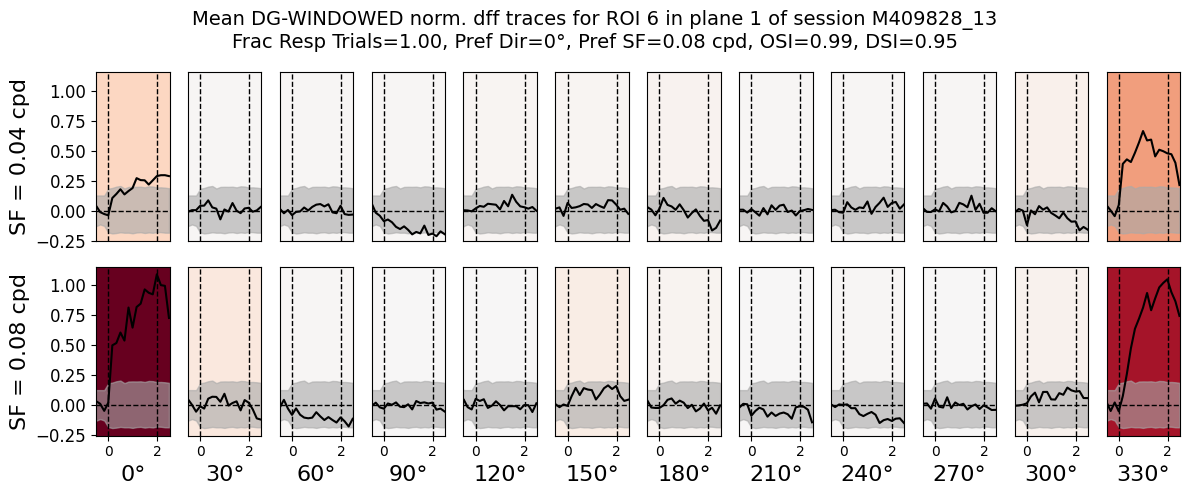

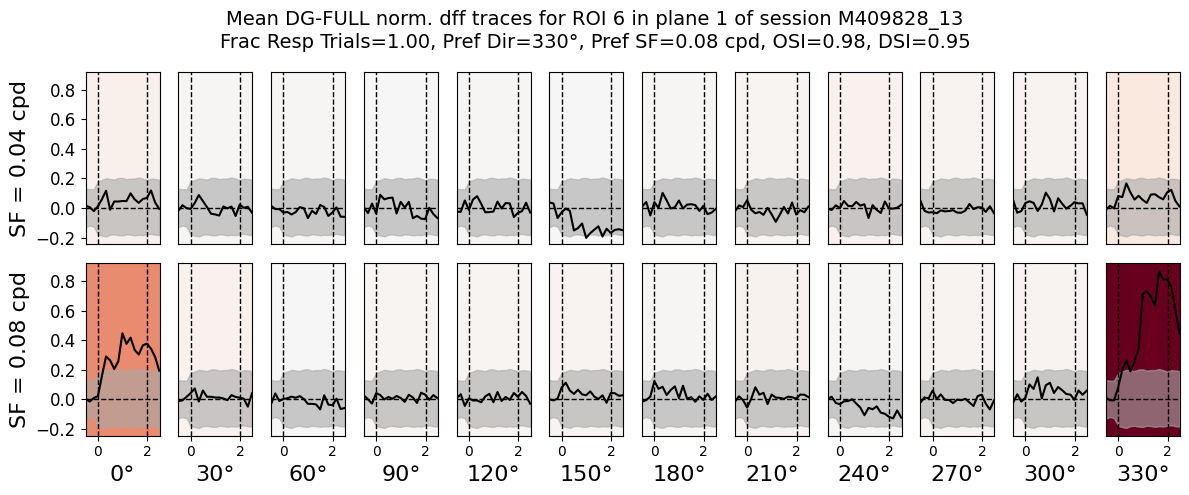

In [32]:
response_plot("M409828_13_1_6", plot="condition_response", trace_type="events")
response_plot("M409828_13_1_6", plot="condition_response", trace_type="dff")

SSI of M409828_13_1_64 = 0.0537


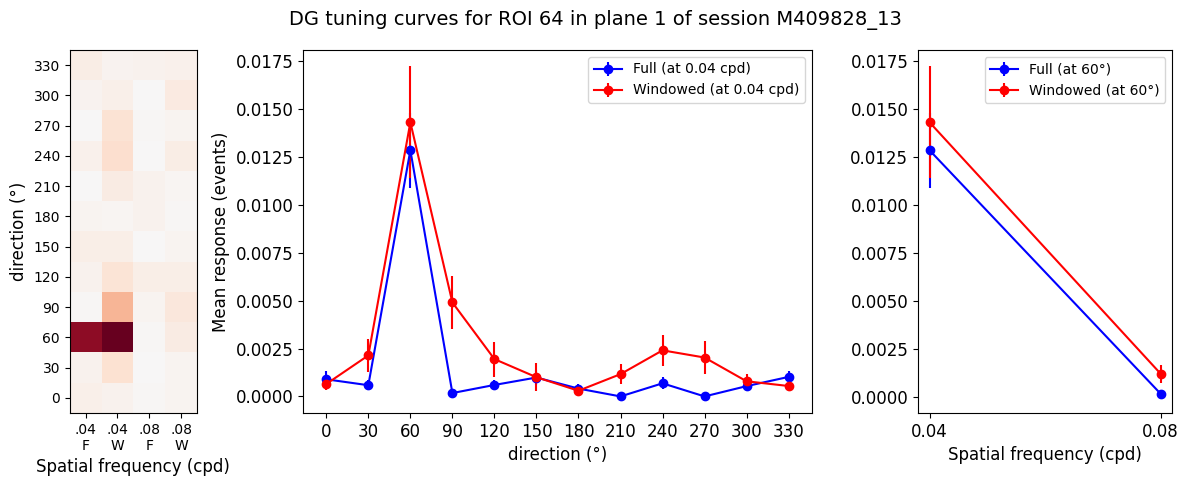

In [52]:
response_plot("M409828_13_1_64", plot="tuning")

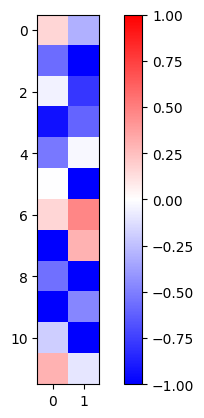

In [145]:
def ssi(f, w):
    return 0 if f == -w else (f-w)/(f+w)

matrix = np.zeros((len(dg_full.dir_list), len(dg_full.sf_list)))

roi = 64
for dir_i, dir in enumerate(dg_full.dir_list):
    for sf_i, sf in enumerate(dg_full.sf_list):
        resp_f = dg_full.get_mean_response(roi, dir_i, sf_i)
        resp_w = dg_windowed.get_mean_response(roi, dir_i, sf_i)
        matrix[dir_i, sf_i] = ssi(resp_f, resp_w)

plt.imshow(matrix, cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()

## Compare preferred orientations for ROIs across DG type

In [43]:
np.mean(~np.logical_xor((dgf_metrics.chisq_response_p < 0.01), (dgf_metrics.frac_responsive_trials >= 0.5)))

0.8385093167701864

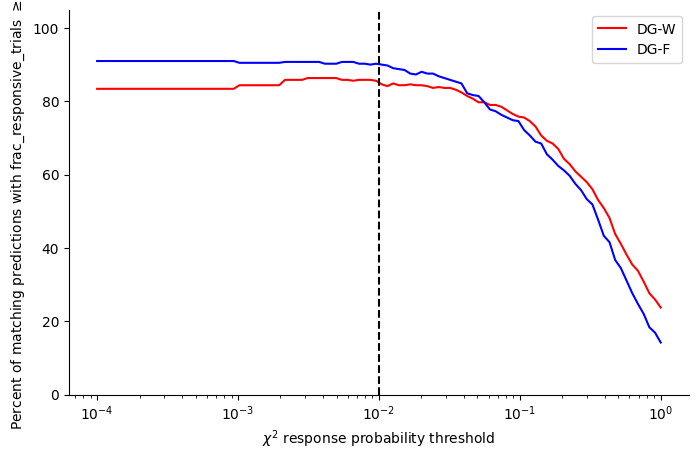

In [33]:

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
x = np.logspace(-4, 0, 100)
# ~np.logical_xor(a, b)[i] := (a[i] == b[i])

y_w = [np.mean(~np.logical_xor((dgw_metrics.chisq_response_p < xx), (dgw_metrics.frac_responsive_trials >= 0.5)))*100 for xx in x]
y_f = [np.mean(~np.logical_xor((dgf_metrics.chisq_response_p < xx), (dgf_metrics.frac_responsive_trials >= 0.5)))*100 for xx in x]
ax.plot(x, y_w, color="red", label="DG-W")
ax.plot(x, y_f, color="blue", label="DG-F")

ax.legend()
ax.set_xlabel(r"$\chi^2$ response probability threshold")
ax.set_ylabel("Percent of matching predictions with frac_responsive_trials $\geq 0.5$")
# ax.set_xlim(-0.02, 1.02)
ax.set_ylim(0, 105)
ax.axvline(x=0.01, color="black", linestyle="dashed")
ax.set_xscale("log")
ax.spines[["top", "right"]].set_visible(False)

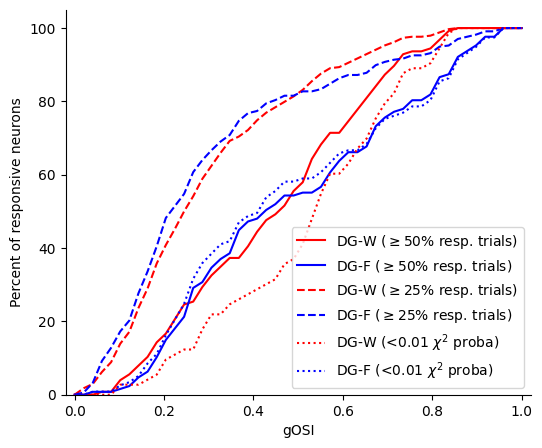

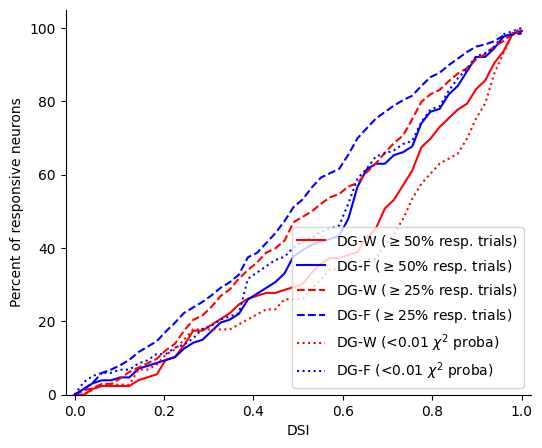

In [48]:
inclusion_criteria = [
    (r"$\geq 50$% resp. trials", lambda df: df.frac_responsive_trials >= 0.5),
    (r"$\geq 25$% resp. trials", lambda df: df.frac_responsive_trials >= 0.25),
    (r"<0.01 $\chi^2$ proba", lambda df: df.chisq_response_p < 0.01),
]

for metric_label, metric in (
    ("gOSI", "gosi"),
    ("DSI", "dsi")
):
    fig, ax = plt.subplots(figsize=(6, 5), facecolor="white")
    x = np.linspace(0, 1)
    i = 0

    for inclusion_label, inclusion in inclusion_criteria:
        inclusion_w = inclusion(dgw_metrics)
        inclusion_f = inclusion(dgf_metrics)
        y_w = [np.mean(dgw_metrics[metric][inclusion_w] < xx)*100 for xx in x]
        y_f = [np.mean(dgf_metrics[metric][inclusion_f] < xx)*100 for xx in x]
        linestyle = ["solid", "dashed", "dotted"][i]
        ax.plot(x, y_w, color="red", linestyle=linestyle, label=f"DG-W ({inclusion_label})")
        ax.plot(x, y_f, color="blue", linestyle=linestyle, label=f"DG-F ({inclusion_label})")
        i += 1

    ax.legend(loc="lower right")
    ax.set_xlabel(metric_label)
    ax.set_ylabel("Percent of responsive neurons")
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(0, 105)
    ax.spines[["top", "right"]].set_visible(False)

In [29]:
dgw_metrics.gosi_naive

M409828_13_1_0       0.09386
M409828_13_1_1      0.155637
M409828_13_1_2      0.199779
M409828_13_1_3      0.265674
M409828_13_1_4       0.02125
                      ...   
M409828_13_1_791    0.122273
M409828_13_1_799    0.342293
M409828_13_1_805    0.174286
M409828_13_1_827    0.106125
M409828_13_1_842    0.196155
Name: gosi_naive, Length: 409, dtype: Float64

In [49]:
inclusion = dgf_metrics.is_responsive & dgw_metrics.is_responsive
inclusion = (dgf_metrics.frac_responsive_trials_naive >= 0.5) | (dgw_metrics.frac_responsive_trials_naive >= 0.5)
inclusion = (dgf_metrics.chisq_response_p < 0.01) | (dgw_metrics.chisq_response_p < 0.01)
# inclusion = (dgw_metrics.z_score > 4) & (dgf_metrics.z_score > 4)
# inclusion = (dg_full.metrics.frac_responsive_trials >= 0.5) & (dg_windowed.metrics.frac_responsive_trials >= 0.5)

at.density_scatter(
    dgw_metrics.pref_dir_mean[inclusion], dgf_metrics.pref_dir_mean[inclusion],
    # np.mod(dgw_metrics.pref_dir_mean[inclusion], 180), np.mod(dgf_metrics.pref_dir_mean[inclusion], 180),
    xlabel="DG-W pref dir mean",
    ylabel="DG-F pref dir mean",
    figsize=(5, 5),
).axis("equal")
# at.density_scatter(dgw_metrics.pref_dir[inclusion], dgw_metrics.pref_dir_mean[inclusion], figsize=(5, 5), xlabel="DG-W pref dir", ylabel="DG-W pref dir mean").axis("equal")
# at.density_scatter(dgf_metrics.pref_dir[inclusion], dgf_metrics.pref_dir_mean[inclusion], figsize=(5, 5), xlabel="DG-F pref dir", ylabel="DG-F pref dir mean").axis("equal")

AttributeError: 'DataFrame' object has no attribute 'frac_responsive_trials_naive'

In [43]:
np.mean(inclusion)

0.38847858197932056

In [12]:
dgw_metrics.is_responsive.value_counts(normalize=True)

True     0.655257
False    0.344743
Name: is_responsive, dtype: Float64

In [13]:
dg_windowed.metrics.loc[6], dg_full.metrics.loc[6]

(is_valid                         1.0
 pref_dir                         0.0
 pref_sf                         0.08
 pref_dir_idx                     0.0
 pref_sf_idx                      1.0
 pref_dir_mean             352.630738
 pref_sf_mean                    0.08
 osi                         0.785914
 dsi                         0.852056
 pref_dir_naive                   0.0
 pref_sf_naive                   0.08
 pref_dir_naive_idx               0.0
 pref_sf_naive_idx                1.0
 z_score                    43.418798
 z_score_naive              57.369158
 response_p                       0.0
 response_p_naive                 0.0
 osi_notcrossval             0.786891
 osi_naive                   0.786891
 frac_responsive_trials           1.0
 is_responsive                    1.0
 lifetime_sparseness         0.894862
 p_trial_responses                0.0
 sig_trial_responses              1.0
 pref_ori                         0.0
 pref_ori_naive                   0.0
 Name: 6, dt

### Compute surround suppression metrics

In [34]:
ss_metrics_all = DriftingGratings.compute_surround_suppression_metrics(dg_full=dg_full, dg_windowed=dg_windowed)
ss_metrics = ss_metrics_all[ss_metrics_all.is_valid]
ss_metrics

,mouse,column,volume,plane,roi,is_valid,depth,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs
M409828_13_1_0,409828,1,3,1,0,True,242,0.000684,0.000000,1.000000,1.000000,-0.039936,0.440227,"[-0.7388674486234882, 1.0, 0.16036562746200944..."
M409828_13_1_1,409828,1,3,1,1,True,242,0.000491,0.000845,0.171957,0.293453,0.106115,-0.065299,"[0.2934529351850714, 0.5393344340481533, 0.785..."
M409828_13_1_2,409828,1,3,1,2,True,242,0.000343,0.000183,0.680372,0.809787,-0.017128,-0.048918,"[1.0, -1.0178392083877414, -1.3804271455555055..."
M409828_13_1_3,409828,1,3,1,3,True,242,0.001798,0.002335,-0.129980,-0.298797,-0.129980,-0.408524,"[-0.2900138538477007, -3.4116620791014616, 0.0..."
M409828_13_1_4,409828,1,3,1,4,True,242,0.000535,0.000571,0.338075,0.505316,-0.118125,-0.337518,"[0.06863248015239432, 1.0, 1.0, -0.84769715972..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_1_791,409828,1,3,1,791,True,242,0.000695,0.000958,0.141193,0.247448,0.043190,0.151446,"[-0.42183818086650954, 0.7217042402897366, 0.3..."
M409828_13_1_799,409828,1,3,1,799,True,242,0.000381,0.001081,0.185508,0.312959,-0.164680,0.015604,"[0.3129593016670482, -0.05943812596333417, -3...."
M409828_13_1_805,409828,1,3,1,805,True,242,0.000803,0.001018,0.162216,0.279149,-0.006264,0.236172,"[-0.7824338808446362, -2.2342110620818474, 1.0..."
M409828_13_1_827,409828,1,3,1,827,True,242,0.000248,0.000654,0.264466,0.418305,-0.039789,0.008235,"[0, 0.6542322211906287, 0.6852986890315732, 0...."


(array([ 0.,  2.,  3.,  1.,  1.,  4.,  2.,  6.,  5., 12., 24., 22., 47.,
        51., 49., 50., 42., 18., 35.]),
 array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]),
 <BarContainer object of 19 artists>)

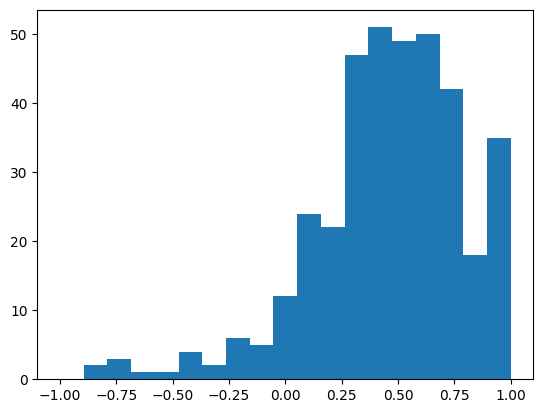

In [35]:
plt.hist(ss_metrics.ssi[dgw_metrics.is_responsive], bins=np.linspace(-1, 1, 20))

## Plot ROIs with SSI

In [36]:
"M409828_13_3_0" in ss_metrics.index

False

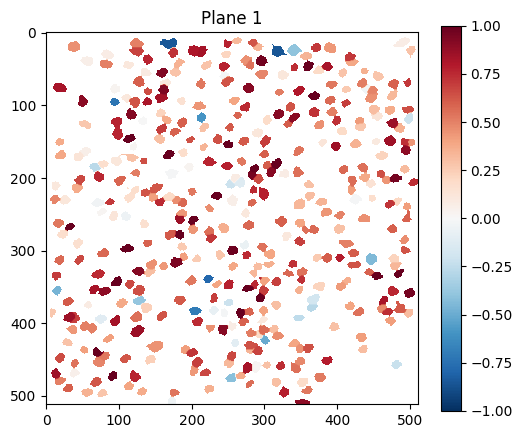

In [38]:
for plane in ss_metrics.plane.unique():
    mask = None
    for roi in sess.get_rois(plane):
        df_index = f"M{mouse}_{col}{vol}_{plane}_{roi}"

        if df_index in ss_metrics.index:
            ssi = ss_metrics.at[df_index, "ssi"]
            
            if abs(ssi) >= 0.25 or True:
                roi_mask = sess.get_roi_image_mask(plane, roi).astype(float)
                roi_mask *= ssi
                roi_mask[roi_mask == 0] = -np.inf
                mask = roi_mask if mask is None else np.maximum(mask, roi_mask)


    mask[(mask == 0) | (mask == -np.inf)] = np.nan
    fig, ax = plt.subplots(figsize=(6, 5), facecolor="white")
    im = ax.imshow(mask, cmap="RdBu_r", vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Plane {plane}")